# XGBoost Model Training with Synthetic Data and Dual Validation

## Objective

This notebook trains an XGBoost classifier to detect fraudulent transactions. The primary goal is to investigate the impact of augmenting the training data with synthetically generated fraud samples while carefully evaluating the model's performance using both a standard validation set and a synthetically augmented validation set.

## Methodology

1.  **Data Loading:**
    *   Loads preprocessed training (`X_train.csv`, `y_train.csv`), validation (`X_val.csv`, `y_val.csv`), and test (`X_test.csv`, `y_test.csv`) datasets.
    *   Loads synthetically generated fraud data (`synthetic_fraud_v*.csv`).
    *   Ensures categorical features are represented numerically.

2.  **Data Augmentation Strategy:**
    *   **Goal:** Add synthetic fraud samples to the training data to improve model robustness, especially for the minority fraud class. A specific `SYNTHETIC_RATIO` (e.g., 1.0 for 1:1 ratio with real fraud) determines the target number of synthetic samples relative to real fraud samples.
    *   **Allocation:** Calculates the desired number of synthetic samples for *both* the training and validation sets based on the `SYNTHETIC_RATIO` and the number of real fraud examples in each original set.
    *   **Adjustment:** If the total desired number exceeds the available synthetic samples, the allocation is adjusted proportionally to use all available synthetic data while maintaining the intended train/validation split ratio.
    *   **Splitting:** Available synthetic data is randomly split into training and validation augmentation sets.

3.  **Dual Validation Sets:**
    *   **Combined Training Set (`X_train_combined`, `y_train_combined`):** The original training data concatenated with the allocated synthetic training samples.
    *   **Pure Validation Set (`X_val_pure`, `y_val_pure`):** The original, untouched validation set. Used for unbiased evaluation and optimal threshold determination.
    *   **Synthetic Validation Set (`X_val_synthetic`, `y_val_synthetic`):** The original validation data concatenated with the allocated synthetic validation samples. Used to monitor how the model performs on a validation set reflecting the augmented data distribution.

4.  **Sample Weighting:**
    *   A `SYNTHETIC_WEIGHT` (e.g., 0.5) is applied to the synthetic samples added to the **combined training set** and the **synthetic validation set**. This allows controlling the influence of synthetic data during the training process and its evaluation metric calculation on the synthetic validation set.

5.  **XGBoost Model Training:**
    *   An XGBoost classifier (`xgb.train`) is initialized with specified hyperparameters (e.g., `learning_rate`, `max_depth`, `objective='binary:logistic'`, `tree_method='hist'`).
    *   The model is trained on the `dtrain` DMatrix (created from the combined training set with sample weights).
    *   **Evaluation During Training:** The model's performance is monitored during training using three evaluation sets:
        *   `dtrain` (combined training data)
        *   `dval_pure` (pure validation data)
        *   `dval_synthetic` (synthetic validation data with sample weights)
    *   **Metrics:** `logloss`, `auc`, and a custom `pr_auc` (Precision-Recall Area Under Curve) are tracked for all evaluation sets.
    *   **Early Stopping:** Training stops early if the performance (likely based on a metric from `dval_synthetic` as it's the last in `eval_sets`) doesn't improve for a specified number of rounds (`early_stopping_rounds=30`).

6.  **Optimal Threshold Selection:**
    *   After training, the optimal probability threshold for classifying transactions as fraud is determined by maximizing the F1 score on the **pure validation set** (`val_pure`). This ensures the threshold is tuned based on real-world data distribution.

7.  **Final Evaluation:**
    *   Predictions are generated for the training, pure validation, synthetic validation, and test sets.
    *   A comprehensive suite of metrics (ROC-AUC, PR-AUC, F1-Score, Sensitivity (Recall), Specificity, Precision, Confusion Matrix) is calculated for all datasets using the determined optimal threshold.

## Experiment Management & Outputs

*   **Directory Structure:** A unique directory named `Experiments/xgboost_synthetic_YYYYMMDD_HHMMSS` is created for each run to store all results and artifacts.
*   **Saved Artifacts:**
    *   `models/model.json`: The trained XGBoost model.
    *   `results/predictions.csv`: Test set true labels, predicted probabilities, and final predictions.
    *   `results/metrics.json`: A JSON file containing all calculated metrics for train, validation (pure & synthetic), and test sets, along with training parameters and the optimal threshold.
    *   `results/feature_importance.csv`: Feature importance scores (gain-based) from the trained model.
    *   `plots/model_evaluation.png`: A plot containing subplots for Top 10 Feature Importance, ROC Curve, Precision-Recall Curve, and Confusion Matrix based on the test set results.

*   **Console Output:** Key steps, data shapes, training progress, the optimal threshold, and final test set metrics are printed to the console.

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc, 
    f1_score, confusion_matrix, precision_score, 
    recall_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Constants and Configuration
RANDOM_SEED = 42
SYNTHETIC_RATIO = 1.0  # Ratio of synthetic to real fraud samples
SYNTHETIC_WEIGHT = 0.5  # Weight for synthetic samples in training
np.random.seed(RANDOM_SEED)

# Create timestamp for experiment
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
experiment_name = f"xgboost_synthetic_{timestamp}"

# Create directory structure for this experiment
base_dir = "Experiments"
experiment_dir = os.path.join(base_dir, experiment_name)
models_dir = os.path.join(experiment_dir, "models")
results_dir = os.path.join(experiment_dir, "results")
plots_dir = os.path.join(experiment_dir, "plots")

for directory in [experiment_dir, models_dir, results_dir, plots_dir]:
    os.makedirs(directory, exist_ok=True)

# Helper functions for metrics
def calculate_metrics(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate basic metrics
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    # Calculate threshold-dependent metrics
    f1 = f1_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    precision_score_val = precision_score(y_true, y_pred)
    
    return {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'f1_score': f1,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision_score_val,
        'confusion_matrix': {
            'tn': int(tn),
            'fp': int(fp),
            'fn': int(fn),
            'tp': int(tp)
        }
    }

def find_optimal_threshold(y_true, y_pred_proba):
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold

def convert_to_serializable(obj):
    if isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_to_serializable(x) for x in obj]
    return obj

# Function to ensure all columns are numeric
def ensure_numeric(df):
    cat_columns = ['merchant', 'category', 'gender', 'street', 'city', 'state', 'zip', 'job']
    for col in cat_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col])
    return df

# Load and prepare data
print("Loading and preparing data with dual validation approach...")

# Load original training data with correct data types
X_train_orig = pd.read_csv('Data/processed/X_train.csv')
y_train_orig = pd.read_csv('Data/processed/y_train.csv').iloc[:, 0]

# Load validation and test data
X_val = pd.read_csv('Data/processed/X_val.csv')
y_val = pd.read_csv('Data/processed/y_val.csv').iloc[:, 0]
X_test = pd.read_csv('Data/processed/X_test.csv')
y_test = pd.read_csv('Data/processed/y_test.csv').iloc[:, 0]

# Load synthetic fraud data
X_synthetic = pd.read_csv('Data/synthetic_fraud_v7_normalized.csv')
y_synthetic = pd.Series(np.ones(len(X_synthetic), dtype=int))

# Ensure all dataframes have numeric data types
X_train_orig = ensure_numeric(X_train_orig)
X_val = ensure_numeric(X_val)
X_test = ensure_numeric(X_test)
X_synthetic = ensure_numeric(X_synthetic)

print(f"Loaded {len(X_synthetic)} synthetic samples")

# Calculate available synthetic ratio
real_fraud_count = y_train_orig.sum()
val_fraud_count = y_val.sum()
available_synthetic = len(X_synthetic)

# Calculate desired synthetic samples based on ratio
desired_train = int(real_fraud_count * SYNTHETIC_RATIO)
desired_val = int(val_fraud_count * SYNTHETIC_RATIO)
total_desired = desired_train + desired_val

print(f"Real fraud samples in training: {real_fraud_count}")
print(f"Desired synthetic samples for training: {desired_train} ({SYNTHETIC_RATIO*100:.1f}% of real fraud)")
print(f"Real fraud samples in validation: {val_fraud_count}")
print(f"Desired synthetic samples for validation: {desired_val} ({SYNTHETIC_RATIO*100:.1f}% of real fraud)")

# Adjust if we don't have enough synthetic samples
if total_desired > available_synthetic:
    print(f"Warning: Not enough synthetic samples available. Adjusting allocation.")
    print(f"Total desired: {total_desired}, Available: {available_synthetic}")
    
    # Maintain the same ratio between training and validation
    train_proportion = desired_train / total_desired
    
    # Adjust the number of samples
    synthetic_train_to_use = int(available_synthetic * train_proportion)
    synthetic_val_to_use = available_synthetic - synthetic_train_to_use
    
    print(f"Adjusted training synthetic samples: {synthetic_train_to_use}")
    print(f"Adjusted validation synthetic samples: {synthetic_val_to_use}")
else:
    synthetic_train_to_use = desired_train
    synthetic_val_to_use = desired_val

# Create training set with synthetic data
indices = np.random.permutation(len(X_synthetic))
train_synthetic_indices = indices[:synthetic_train_to_use]
val_synthetic_indices = indices[synthetic_train_to_use:synthetic_train_to_use+synthetic_val_to_use]

X_synthetic_train = X_synthetic.iloc[train_synthetic_indices].reset_index(drop=True)
y_synthetic_train = y_synthetic.iloc[train_synthetic_indices].reset_index(drop=True)

X_synthetic_val = X_synthetic.iloc[val_synthetic_indices].reset_index(drop=True)
y_synthetic_val = y_synthetic.iloc[val_synthetic_indices].reset_index(drop=True)

# Combine training data
X_train_combined = pd.concat([X_train_orig, X_synthetic_train], ignore_index=True)
y_train_combined = pd.concat([y_train_orig, y_synthetic_train], ignore_index=True)

# Create validation sets
X_val_pure = X_val.copy()
y_val_pure = y_val.copy()

X_val_synthetic = pd.concat([X_val, X_synthetic_val], ignore_index=True)
y_val_synthetic = pd.concat([y_val, y_synthetic_val], ignore_index=True)

# Print validation set information
print("\nValidation set sizes:")
print(f"Pure validation total samples: {len(y_val_pure)}")
print(f"Pure validation fraud samples: {y_val_pure.sum()}")
print(f"Synthetic validation total samples: {len(y_val_synthetic)}")
print(f"Synthetic validation fraud samples: {y_val_synthetic.sum()}")
print(f"Added synthetic fraud samples: {len(y_synthetic_val)}")

# Create sample weights
sample_weights = np.ones(len(X_train_combined))
synthetic_indices = list(range(len(X_train_orig), len(X_train_combined)))
sample_weights[synthetic_indices] = SYNTHETIC_WEIGHT

val_sample_weights = np.ones(len(X_val_synthetic))
val_synthetic_indices = list(range(len(X_val), len(X_val_synthetic)))
val_sample_weights[val_synthetic_indices] = SYNTHETIC_WEIGHT

print(f"\nTraining data shapes:")
print(f"Combined training: {X_train_combined.shape}")
print(f"Pure validation: {X_val_pure.shape}")
print(f"Synthetic validation: {X_val_synthetic.shape}")
print(f"Test: {X_test.shape}")

# Check data types before creating DMatrix
print("\nChecking data types...")
for col in X_train_combined.columns:
    print(f"{col}: {X_train_combined[col].dtype}")

# Initialize XGBoost model
print("\nTraining XGBoost model with dual validation...")
xgb_params = {
    'learning_rate': 0.05,
    'max_depth': 5,
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'auc'],
    'tree_method': 'hist',
    'random_state': RANDOM_SEED
}

# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train_combined, label=y_train_combined, weight=sample_weights)
dval_pure = xgb.DMatrix(X_val_pure, label=y_val_pure)
dval_synthetic = xgb.DMatrix(X_val_synthetic, label=y_val_synthetic, weight=val_sample_weights)
dtest = xgb.DMatrix(X_test, label=y_test)

# Custom evaluation function for PR-AUC
def custom_pr_auc(preds, dtrain):
    labels = dtrain.get_label()
    precision, recall, _ = precision_recall_curve(labels, preds)
    pr_auc = auc(recall, precision)
    return 'pr_auc', pr_auc

# Training parameters
eval_results = {}
eval_sets = [
    (dtrain, 'train'),
    (dval_pure, 'val_pure'),
    (dval_synthetic, 'val_synthetic')
]

# Train the model
model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=300,
    evals=eval_sets,
    evals_result=eval_results,
    custom_metric=custom_pr_auc,
    early_stopping_rounds=30,
    verbose_eval=10
)

print("\nModel training completed. Evaluating performance...")

# Generate predictions
train_pred_proba = model.predict(dtrain)
val_pure_pred_proba = model.predict(dval_pure)
val_synthetic_pred_proba = model.predict(dval_synthetic)
test_pred_proba = model.predict(dtest)

# Find optimal threshold using pure validation set
optimal_threshold = find_optimal_threshold(y_val_pure, val_pure_pred_proba)
print(f"\nOptimal threshold: {optimal_threshold:.3f}")

# Calculate metrics for all sets
train_metrics = calculate_metrics(y_train_combined, train_pred_proba, optimal_threshold)
val_pure_metrics = calculate_metrics(y_val_pure, val_pure_pred_proba, optimal_threshold)
val_synthetic_metrics = calculate_metrics(y_val_synthetic, val_synthetic_pred_proba, optimal_threshold)
test_metrics = calculate_metrics(y_test, test_pred_proba, optimal_threshold)

# Save predictions
predictions_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred_proba': test_pred_proba,
    'y_pred': (test_pred_proba >= optimal_threshold).astype(int)
})
predictions_df.to_csv(os.path.join(results_dir, 'predictions.csv'), index=False)

# Save metrics
metrics_dict = {
    'optimal_threshold': optimal_threshold,
    'training': train_metrics,
    'validation_pure': val_pure_metrics,
    'validation_synthetic': val_synthetic_metrics,
    'test': test_metrics,
    'training_params': {
        'synthetic_ratio': SYNTHETIC_RATIO,
        'synthetic_weight': SYNTHETIC_WEIGHT,
        'learning_rate': xgb_params['learning_rate'],
        'max_depth': xgb_params['max_depth']
    }
}

metrics_dict = convert_to_serializable(metrics_dict)
with open(os.path.join(results_dir, 'metrics.json'), 'w') as f:
    json.dump(metrics_dict, f, indent=4)

# Save feature importance
importance_scores = model.get_score(importance_type='gain')
features = list(importance_scores.keys())
importances = list(importance_scores.values())

feature_importance = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

# Add features with zero importance
missing_features = set(X_train_combined.columns) - set(feature_importance['feature'])
if missing_features:
    missing_df = pd.DataFrame({
        'feature': list(missing_features),
        'importance': [0] * len(missing_features)
    })
    feature_importance = pd.concat([feature_importance, missing_df], ignore_index=True)

feature_importance = feature_importance.sort_values('importance', ascending=False)
feature_importance.to_csv(os.path.join(results_dir, 'feature_importance.csv'), index=False)

# Create and save visualizations
plt.figure(figsize=(20, 15))

# Feature Importance Plot
plt.subplot(2, 2, 1)
top_features = feature_importance.head(10)
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 10 Feature Importance')

# ROC Curve
plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, test_pred_proba)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {test_metrics["roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
plt.subplot(2, 2, 3)
precision, recall, _ = precision_recall_curve(y_test, test_pred_proba)
plt.plot(recall, precision, label=f'PR curve (AP = {test_metrics["pr_auc"]:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# Confusion Matrix
plt.subplot(2, 2, 4)
cm = confusion_matrix(y_test, (test_pred_proba >= optimal_threshold).astype(int))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'model_evaluation.png'))
plt.close()

# Save model
model.save_model(os.path.join(models_dir, 'model.json'))

print("\nExperiment completed! Results saved in:", experiment_dir)
print("\nTest Set Metrics:")
print(f"ROC-AUC: {test_metrics['roc_auc']:.4f}")
print(f"PR-AUC: {test_metrics['pr_auc']:.4f}")
print(f"F1 Score: {test_metrics['f1_score']:.4f}")
print(f"Sensitivity: {test_metrics['sensitivity']:.4f}")
print(f"Specificity: {test_metrics['specificity']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")

Loading and preparing data with dual validation approach...
Loaded 5000 synthetic samples
Real fraud samples in training: 6273
Desired synthetic samples for training: 6273 (100.0% of real fraud)
Real fraud samples in validation: 1448
Desired synthetic samples for validation: 1448 (100.0% of real fraud)
Total desired: 7721, Available: 5000
Adjusted training synthetic samples: 4062
Adjusted validation synthetic samples: 938

Validation set sizes:
Pure validation total samples: 277860
Pure validation fraud samples: 1448
Synthetic validation total samples: 278798
Synthetic validation fraud samples: 2386
Added synthetic fraud samples: 938

Training data shapes:
Combined training: (1208117, 19)
Pure validation: (277860, 19)
Synthetic validation: (278798, 19)
Test: (370479, 19)

Checking data types...
merchant: int64
category: int64
amt: float64
gender: int64
street: int64
city: int64
state: int64
zip: int64
lat: float64
long: float64
city_pop: float64
job: int64
merch_lat: float64
merch_long

Loading and preparing data with dual validation approach...
Loaded 5000 synthetic samples
Real fraud samples in training: 6273
Desired synthetic samples for training: 6273 (100.0% of real fraud)
Real fraud samples in validation: 1448
Desired synthetic samples for validation: 1448 (100.0% of real fraud)
Total desired: 7721, Available: 5000
Adjusted training synthetic samples: 4062
Adjusted validation synthetic samples: 938

Validation set sizes:
Pure validation total samples: 277860
Pure validation fraud samples: 1448
Synthetic validation total samples: 278798
Synthetic validation fraud samples: 2386
Added synthetic fraud samples: 938

Training data shapes:
Combined training: (1208117, 19)
Pure validation: (277860, 19)
Synthetic validation: (278798, 19)
Test: (370479, 19)
scale_pos_weight: 115.90

Training XGBoost model with parameters from XG_Boost_Augmented.py...

Initial model training:
[0]	validation_0-auc:0.97847	validation_0-aucpr:0.47688	validation_1-auc:0.98048	validation_1-aucp

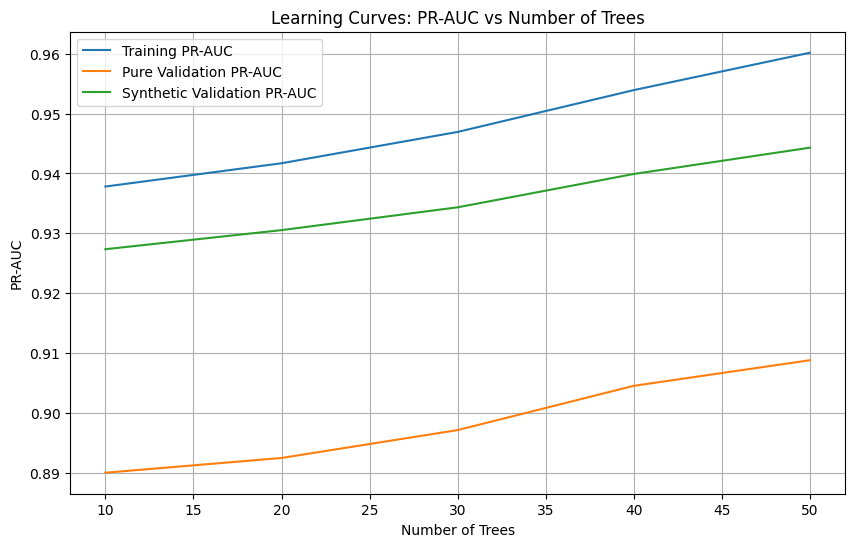

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc, 
    f1_score, confusion_matrix, precision_score, 
    recall_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Constants and Configuration
RANDOM_SEED = 42
SYNTHETIC_RATIO = 1.0  # Ratio of synthetic to real fraud samples
SYNTHETIC_WEIGHT = 0.5  # Weight for synthetic samples in training
np.random.seed(RANDOM_SEED)

# Create timestamp for experiment
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
experiment_name = f"xgboost_synthetic_{timestamp}"

# Create directory structure for this experiment
base_dir = "Experiments"
experiment_dir = os.path.join(base_dir, experiment_name)
models_dir = os.path.join(experiment_dir, "models")
results_dir = os.path.join(experiment_dir, "results")
plots_dir = os.path.join(experiment_dir, "plots")

for directory in [experiment_dir, models_dir, results_dir, plots_dir]:
    os.makedirs(directory, exist_ok=True)

# Helper functions for metrics
def calculate_metrics(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate basic metrics
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    # Calculate threshold-dependent metrics
    f1 = f1_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    precision_score_val = precision_score(y_true, y_pred)
    
    return {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'f1_score': f1,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision_score_val,
        'confusion_matrix': {
            'tn': int(tn),
            'fp': int(fp),
            'fn': int(fn),
            'tp': int(tp)
        }
    }

def find_optimal_threshold(y_true, y_pred_proba):
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold

def convert_to_serializable(obj):
    if isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_to_serializable(x) for x in obj]
    return obj

# Function to ensure all columns are numeric
def ensure_numeric(df):
    cat_columns = ['merchant', 'category', 'gender', 'street', 'city', 'state', 'zip', 'job']
    for col in cat_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col])
    return df

# Load and prepare data
print("Loading and preparing data with dual validation approach...")

# Load original training data with correct data types
X_train_orig = pd.read_csv('Data/processed/X_train.csv')
y_train_orig = pd.read_csv('Data/processed/y_train.csv').iloc[:, 0]

# Load validation and test data
X_val = pd.read_csv('Data/processed/X_val.csv')
y_val = pd.read_csv('Data/processed/y_val.csv').iloc[:, 0]
X_test = pd.read_csv('Data/processed/X_test.csv')
y_test = pd.read_csv('Data/processed/y_test.csv').iloc[:, 0]

# Load synthetic fraud data
X_synthetic = pd.read_csv('Data/synthetic_fraud_v7_normalized.csv')
y_synthetic = pd.Series(np.ones(len(X_synthetic), dtype=int))

# Ensure all dataframes have numeric data types
X_train_orig = ensure_numeric(X_train_orig)
X_val = ensure_numeric(X_val)
X_test = ensure_numeric(X_test)
X_synthetic = ensure_numeric(X_synthetic)

print(f"Loaded {len(X_synthetic)} synthetic samples")

# Calculate available synthetic ratio
real_fraud_count = y_train_orig.sum()
val_fraud_count = y_val.sum()
available_synthetic = len(X_synthetic)

# Calculate desired synthetic samples based on ratio
desired_train = int(real_fraud_count * SYNTHETIC_RATIO)
desired_val = int(val_fraud_count * SYNTHETIC_RATIO)
total_desired = desired_train + desired_val

print(f"Real fraud samples in training: {real_fraud_count}")
print(f"Desired synthetic samples for training: {desired_train} ({SYNTHETIC_RATIO*100:.1f}% of real fraud)")
print(f"Real fraud samples in validation: {val_fraud_count}")
print(f"Desired synthetic samples for validation: {desired_val} ({SYNTHETIC_RATIO*100:.1f}% of real fraud)")

# Adjust if we don't have enough synthetic samples
if total_desired > available_synthetic:
    print(f"Warning: Not enough synthetic samples available. Adjusting allocation.")
    print(f"Total desired: {total_desired}, Available: {available_synthetic}")
    
    # Maintain the same ratio between training and validation
    train_proportion = desired_train / total_desired
    
    # Adjust the number of samples
    synthetic_train_to_use = int(available_synthetic * train_proportion)
    synthetic_val_to_use = available_synthetic - synthetic_train_to_use
    
    print(f"Adjusted training synthetic samples: {synthetic_train_to_use}")
    print(f"Adjusted validation synthetic samples: {synthetic_val_to_use}")
else:
    synthetic_train_to_use = desired_train
    synthetic_val_to_use = desired_val

# Create training set with synthetic data
indices = np.random.permutation(len(X_synthetic))
train_synthetic_indices = indices[:synthetic_train_to_use]
val_synthetic_indices = indices[synthetic_train_to_use:synthetic_train_to_use+synthetic_val_to_use]

X_synthetic_train = X_synthetic.iloc[train_synthetic_indices].reset_index(drop=True)
y_synthetic_train = y_synthetic.iloc[train_synthetic_indices].reset_index(drop=True)

X_synthetic_val = X_synthetic.iloc[val_synthetic_indices].reset_index(drop=True)
y_synthetic_val = y_synthetic.iloc[val_synthetic_indices].reset_index(drop=True)

# Combine training data
X_train_combined = pd.concat([X_train_orig, X_synthetic_train], ignore_index=True)
y_train_combined = pd.concat([y_train_orig, y_synthetic_train], ignore_index=True)

# Create validation sets
X_val_pure = X_val.copy()
y_val_pure = y_val.copy()

X_val_synthetic = pd.concat([X_val, X_synthetic_val], ignore_index=True)
y_val_synthetic = pd.concat([y_val, y_synthetic_val], ignore_index=True)

# Create sample weights (for potential future use)
sample_weights = np.ones(len(X_train_combined))
synthetic_indices = list(range(len(X_train_orig), len(X_train_combined)))
sample_weights[synthetic_indices] = SYNTHETIC_WEIGHT

# Calculate scale_pos_weight for both validation sets
neg_count = (y_train_combined == 0).sum()
pos_count = (y_train_combined == 1).sum()
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0

# Print validation set information
print("\nValidation set sizes:")
print(f"Pure validation total samples: {len(y_val_pure)}")
print(f"Pure validation fraud samples: {y_val_pure.sum()}")
print(f"Synthetic validation total samples: {len(y_val_synthetic)}")
print(f"Synthetic validation fraud samples: {y_val_synthetic.sum()}")
print(f"Added synthetic fraud samples: {len(y_synthetic_val)}")

print(f"\nTraining data shapes:")
print(f"Combined training: {X_train_combined.shape}")
print(f"Pure validation: {X_val_pure.shape}")
print(f"Synthetic validation: {X_val_synthetic.shape}")
print(f"Test: {X_test.shape}")
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# Initialize XGBoost model with parameters from XG_Boost_Augmented.py
print("\nTraining XGBoost model with parameters from XG_Boost_Augmented.py...")
start_time = time.time()

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric=['auc', 'aucpr'],
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=300,
    tree_method='hist',
    random_state=42
)

# First, fit the model to get initial training
print("\nInitial model training:")
model.fit(
    X_train_combined, 
    y_train_combined, 
    sample_weight=sample_weights,
    eval_set=[(X_train_combined, y_train_combined), 
              (X_val_pure, y_val_pure), 
              (X_val_synthetic, y_val_synthetic)],
    verbose=True
)

# Then, run manual iterations tracking dual validation (similar to XG_Boost_Augmented.py)
print("\nRunning manual iterations with dual validation tracking:")
best_score_pure = 0
best_score_synthetic = 0
best_iter_pure = 0
best_iter_synthetic = 0
best_model = None

# Create trackers for metrics
iterations = []
train_pr_auc = []
val_pure_pr_auc = []
val_synthetic_pr_auc = []

for i in range(5):  # Reduced number of iterations for testing
    n_trees = (i+1) * 10  # Increase trees by 10 each iteration
    model.n_estimators = n_trees
    model.fit(
        X_train_combined, 
        y_train_combined, 
        sample_weight=sample_weights,
        xgb_model=model.get_booster(),
        eval_set=[(X_train_combined, y_train_combined), 
                  (X_val_pure, y_val_pure), 
                  (X_val_synthetic, y_val_synthetic)],
        verbose=False
    )
    
    # Get predictions
    train_pred = model.predict_proba(X_train_combined)[:, 1]
    val_pure_pred = model.predict_proba(X_val_pure)[:, 1]
    val_synthetic_pred = model.predict_proba(X_val_synthetic)[:, 1]
    
    # Calculate PR-AUC
    precision, recall, _ = precision_recall_curve(y_train_combined, train_pred)
    train_score = auc(recall, precision)
    
    precision, recall, _ = precision_recall_curve(y_val_pure, val_pure_pred)
    val_pure_score = auc(recall, precision)
    
    precision, recall, _ = precision_recall_curve(y_val_synthetic, val_synthetic_pred)
    val_synthetic_score = auc(recall, precision)
    
    # Store metrics
    iterations.append(n_trees)
    train_pr_auc.append(train_score)
    val_pure_pr_auc.append(val_pure_score)
    val_synthetic_pr_auc.append(val_synthetic_score)
    
    # Track best models based on each validation set
    if val_pure_score > best_score_pure:
        best_score_pure = val_pure_score
        best_iter_pure = n_trees
    
    if val_synthetic_score > best_score_synthetic:
        best_score_synthetic = val_synthetic_score
        best_iter_synthetic = n_trees
        best_model = model
    
    print(f"Trees: {n_trees}, Train PR-AUC: {train_score:.4f}, "
          f"Pure Val PR-AUC: {val_pure_score:.4f}, "
          f"Synthetic Val PR-AUC: {val_synthetic_score:.4f}")

print(f"\nTraining completed in {time.time() - start_time:.2f} seconds")
print(f"Best iteration (pure validation): {best_iter_pure} trees, PR-AUC: {best_score_pure:.4f}")
print(f"Best iteration (synthetic validation): {best_iter_synthetic} trees, PR-AUC: {best_score_synthetic:.4f}")

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(iterations, train_pr_auc, label='Training PR-AUC')
plt.plot(iterations, val_pure_pr_auc, label='Pure Validation PR-AUC')
plt.plot(iterations, val_synthetic_pr_auc, label='Synthetic Validation PR-AUC')
plt.xlabel('Number of Trees')
plt.ylabel('PR-AUC')
plt.title('Learning Curves: PR-AUC vs Number of Trees')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(plots_dir, 'learning_curves.png'))

# Use the best model for evaluation
model = best_model

# Generate predictions on test set
test_pred_proba = model.predict_proba(X_test)[:, 1]

# Find optimal threshold using pure validation set
val_pure_pred_proba = model.predict_proba(X_val_pure)[:, 1]
optimal_threshold = find_optimal_threshold(y_val_pure, val_pure_pred_proba)
print(f"\nOptimal threshold: {optimal_threshold:.3f}")

# Calculate metrics
train_pred_proba = model.predict_proba(X_train_combined)[:, 1]
val_synthetic_pred_proba = model.predict_proba(X_val_synthetic)[:, 1]

train_metrics = calculate_metrics(y_train_combined, train_pred_proba, optimal_threshold)
val_pure_metrics = calculate_metrics(y_val_pure, val_pure_pred_proba, optimal_threshold)
val_synthetic_metrics = calculate_metrics(y_val_synthetic, val_synthetic_pred_proba, optimal_threshold)
test_metrics = calculate_metrics(y_test, test_pred_proba, optimal_threshold)

# Save predictions
predictions_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred_proba': test_pred_proba,
    'y_pred': (test_pred_proba >= optimal_threshold).astype(int)
})
predictions_df.to_csv(os.path.join(results_dir, 'predictions.csv'), index=False)

# Save metrics
metrics_dict = {
    'optimal_threshold': optimal_threshold,
    'training': train_metrics,
    'validation_pure': val_pure_metrics,
    'validation_synthetic': val_synthetic_metrics,
    'test': test_metrics,
    'training_params': {
        'synthetic_ratio': SYNTHETIC_RATIO,
        'synthetic_weight': SYNTHETIC_WEIGHT,
        'best_trees_pure': best_iter_pure,
        'best_trees_synthetic': best_iter_synthetic,
        'scale_pos_weight': scale_pos_weight,
        'learning_rate': 0.05,
        'max_depth': 5
    }
}

metrics_dict = convert_to_serializable(metrics_dict)
with open(os.path.join(results_dir, 'metrics.json'), 'w') as f:
    json.dump(metrics_dict, f, indent=4)

# Save feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_combined.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance.to_csv(os.path.join(results_dir, 'feature_importance.csv'), index=False)

# Create and save final visualizations
plt.figure(figsize=(20, 15))

# Feature Importance Plot
plt.subplot(2, 2, 1)
top_features = feature_importance.head(10)
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 10 Feature Importance')

# ROC Curve
plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, test_pred_proba)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {test_metrics["roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
plt.subplot(2, 2, 3)
precision, recall, _ = precision_recall_curve(y_test, test_pred_proba)
plt.plot(recall, precision, label=f'PR curve (AP = {test_metrics["pr_auc"]:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# Confusion Matrix
plt.subplot(2, 2, 4)
cm = confusion_matrix(y_test, (test_pred_proba >= optimal_threshold).astype(int))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'model_evaluation.png'))
plt.close()

# Save model
model.save_model(os.path.join(models_dir, 'model.json'))

print("\nExperiment completed! Results saved in:", experiment_dir)
print("\nTest Set Metrics:")
print(f"ROC-AUC: {test_metrics['roc_auc']:.4f}")
print(f"PR-AUC: {test_metrics['pr_auc']:.4f}")
print(f"F1 Score: {test_metrics['f1_score']:.4f}")
print(f"Sensitivity: {test_metrics['sensitivity']:.4f}")
print(f"Specificity: {test_metrics['specificity']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")

Loading and preparing data with dual validation approach...
Loaded 8000 synthetic samples
Real fraud samples in training: 6273
Desired synthetic samples for training: 6273 (100.0% of real fraud)
Real fraud samples in validation: 1448
Desired synthetic samples for validation: 1448 (100.0% of real fraud)

Validation set sizes:
Pure validation total samples: 277860
Pure validation fraud samples: 1448
Synthetic validation total samples: 279308
Synthetic validation fraud samples: 2896
Added synthetic fraud samples: 1448

Training data shapes:
Combined training: (1210328, 19)
Pure validation: (277860, 19)
Synthetic validation: (279308, 19)
Test: (370479, 19)
scale_pos_weight: 95.47

Training XGBoost model with parameters from XG_Boost_Augmented.py...

Initial model training:
[0]	validation_0-auc:0.97734	validation_0-aucpr:0.49552	validation_1-auc:0.97885	validation_1-aucpr:0.34537	validation_2-auc:0.97624	validation_2-aucpr:0.47676
[1]	validation_0-auc:0.98446	validation_0-aucpr:0.65502	vali

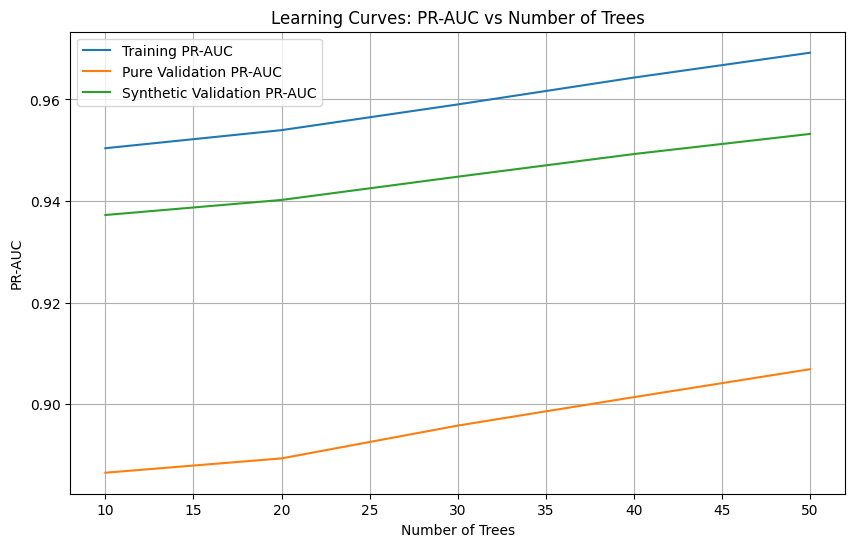

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc, 
    f1_score, confusion_matrix, precision_score, 
    recall_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Constants and Configuration
RANDOM_SEED = 42
SYNTHETIC_RATIO = 1.0  # Ratio of synthetic to real fraud samples
SYNTHETIC_WEIGHT = 0.5  # Weight for synthetic samples in training
np.random.seed(RANDOM_SEED)

# Create timestamp for experiment
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
experiment_name = f"xgboost_synthetic_{timestamp}"

# Create directory structure for this experiment
base_dir = "Experiments"
experiment_dir = os.path.join(base_dir, experiment_name)
models_dir = os.path.join(experiment_dir, "models")
results_dir = os.path.join(experiment_dir, "results")
plots_dir = os.path.join(experiment_dir, "plots")

for directory in [experiment_dir, models_dir, results_dir, plots_dir]:
    os.makedirs(directory, exist_ok=True)

# Helper functions for metrics
def calculate_metrics(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate basic metrics
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    # Calculate threshold-dependent metrics
    f1 = f1_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    precision_score_val = precision_score(y_true, y_pred)
    
    return {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'f1_score': f1,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision_score_val,
        'confusion_matrix': {
            'tn': int(tn),
            'fp': int(fp),
            'fn': int(fn),
            'tp': int(tp)
        }
    }

def find_optimal_threshold(y_true, y_pred_proba):
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold

def convert_to_serializable(obj):
    if isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_to_serializable(x) for x in obj]
    return obj

# Function to ensure all columns are numeric
def ensure_numeric(df):
    cat_columns = ['merchant', 'category', 'gender', 'street', 'city', 'state', 'zip', 'job']
    for col in cat_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col])
    return df

# Load and prepare data
print("Loading and preparing data with dual validation approach...")

# Load original training data with correct data types
X_train_orig = pd.read_csv('Data/processed/X_train.csv')
y_train_orig = pd.read_csv('Data/processed/y_train.csv').iloc[:, 0]

# Load validation and test data
X_val = pd.read_csv('Data/processed/X_val.csv')
y_val = pd.read_csv('Data/processed/y_val.csv').iloc[:, 0]
X_test = pd.read_csv('Data/processed/X_test.csv')
y_test = pd.read_csv('Data/processed/y_test.csv').iloc[:, 0]

# Load synthetic fraud data
X_synthetic = pd.read_csv('Data/synthetic_fraud_v7_normalized_8kpoints.csv')
y_synthetic = pd.Series(np.ones(len(X_synthetic), dtype=int))

# Ensure all dataframes have numeric data types
X_train_orig = ensure_numeric(X_train_orig)
X_val = ensure_numeric(X_val)
X_test = ensure_numeric(X_test)
X_synthetic = ensure_numeric(X_synthetic)

print(f"Loaded {len(X_synthetic)} synthetic samples")

# Calculate available synthetic ratio
real_fraud_count = y_train_orig.sum()
val_fraud_count = y_val.sum()
available_synthetic = len(X_synthetic)

# Calculate desired synthetic samples based on ratio
desired_train = int(real_fraud_count * SYNTHETIC_RATIO)
desired_val = int(val_fraud_count * SYNTHETIC_RATIO)
total_desired = desired_train + desired_val

print(f"Real fraud samples in training: {real_fraud_count}")
print(f"Desired synthetic samples for training: {desired_train} ({SYNTHETIC_RATIO*100:.1f}% of real fraud)")
print(f"Real fraud samples in validation: {val_fraud_count}")
print(f"Desired synthetic samples for validation: {desired_val} ({SYNTHETIC_RATIO*100:.1f}% of real fraud)")

# Adjust if we don't have enough synthetic samples
if total_desired > available_synthetic:
    print(f"Warning: Not enough synthetic samples available. Adjusting allocation.")
    print(f"Total desired: {total_desired}, Available: {available_synthetic}")
    
    # Maintain the same ratio between training and validation
    train_proportion = desired_train / total_desired
    
    # Adjust the number of samples
    synthetic_train_to_use = int(available_synthetic * train_proportion)
    synthetic_val_to_use = available_synthetic - synthetic_train_to_use
    
    print(f"Adjusted training synthetic samples: {synthetic_train_to_use}")
    print(f"Adjusted validation synthetic samples: {synthetic_val_to_use}")
else:
    synthetic_train_to_use = desired_train
    synthetic_val_to_use = desired_val

# Create training set with synthetic data
indices = np.random.permutation(len(X_synthetic))
train_synthetic_indices = indices[:synthetic_train_to_use]
val_synthetic_indices = indices[synthetic_train_to_use:synthetic_train_to_use+synthetic_val_to_use]

X_synthetic_train = X_synthetic.iloc[train_synthetic_indices].reset_index(drop=True)
y_synthetic_train = y_synthetic.iloc[train_synthetic_indices].reset_index(drop=True)

X_synthetic_val = X_synthetic.iloc[val_synthetic_indices].reset_index(drop=True)
y_synthetic_val = y_synthetic.iloc[val_synthetic_indices].reset_index(drop=True)

# Combine training data
X_train_combined = pd.concat([X_train_orig, X_synthetic_train], ignore_index=True)
y_train_combined = pd.concat([y_train_orig, y_synthetic_train], ignore_index=True)

# Create validation sets
X_val_pure = X_val.copy()
y_val_pure = y_val.copy()

X_val_synthetic = pd.concat([X_val, X_synthetic_val], ignore_index=True)
y_val_synthetic = pd.concat([y_val, y_synthetic_val], ignore_index=True)

# Create sample weights (for potential future use)
sample_weights = np.ones(len(X_train_combined))
synthetic_indices = list(range(len(X_train_orig), len(X_train_combined)))
sample_weights[synthetic_indices] = SYNTHETIC_WEIGHT

# Calculate scale_pos_weight for both validation sets
neg_count = (y_train_combined == 0).sum()
pos_count = (y_train_combined == 1).sum()
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0

# Print validation set information
print("\nValidation set sizes:")
print(f"Pure validation total samples: {len(y_val_pure)}")
print(f"Pure validation fraud samples: {y_val_pure.sum()}")
print(f"Synthetic validation total samples: {len(y_val_synthetic)}")
print(f"Synthetic validation fraud samples: {y_val_synthetic.sum()}")
print(f"Added synthetic fraud samples: {len(y_synthetic_val)}")

print(f"\nTraining data shapes:")
print(f"Combined training: {X_train_combined.shape}")
print(f"Pure validation: {X_val_pure.shape}")
print(f"Synthetic validation: {X_val_synthetic.shape}")
print(f"Test: {X_test.shape}")
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# Initialize XGBoost model with parameters from XG_Boost_Augmented.py
print("\nTraining XGBoost model with parameters from XG_Boost_Augmented.py...")
start_time = time.time()

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric=['auc', 'aucpr'],
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=300,
    tree_method='hist',
    random_state=42
)

# First, fit the model to get initial training
print("\nInitial model training:")
model.fit(
    X_train_combined, 
    y_train_combined, 
    sample_weight=sample_weights,
    eval_set=[(X_train_combined, y_train_combined), 
              (X_val_pure, y_val_pure), 
              (X_val_synthetic, y_val_synthetic)],
    verbose=True
)

# Then, run manual iterations tracking dual validation (similar to XG_Boost_Augmented.py)
print("\nRunning manual iterations with dual validation tracking:")
best_score_pure = 0
best_score_synthetic = 0
best_iter_pure = 0
best_iter_synthetic = 0
best_model = None

# Create trackers for metrics
iterations = []
train_pr_auc = []
val_pure_pr_auc = []
val_synthetic_pr_auc = []

for i in range(5):  # Reduced number of iterations for testing
    n_trees = (i+1) * 10  # Increase trees by 10 each iteration
    model.n_estimators = n_trees
    model.fit(
        X_train_combined, 
        y_train_combined, 
        sample_weight=sample_weights,
        xgb_model=model.get_booster(),
        eval_set=[(X_train_combined, y_train_combined), 
                  (X_val_pure, y_val_pure), 
                  (X_val_synthetic, y_val_synthetic)],
        verbose=False
    )
    
    # Get predictions
    train_pred = model.predict_proba(X_train_combined)[:, 1]
    val_pure_pred = model.predict_proba(X_val_pure)[:, 1]
    val_synthetic_pred = model.predict_proba(X_val_synthetic)[:, 1]
    
    # Calculate PR-AUC
    precision, recall, _ = precision_recall_curve(y_train_combined, train_pred)
    train_score = auc(recall, precision)
    
    precision, recall, _ = precision_recall_curve(y_val_pure, val_pure_pred)
    val_pure_score = auc(recall, precision)
    
    precision, recall, _ = precision_recall_curve(y_val_synthetic, val_synthetic_pred)
    val_synthetic_score = auc(recall, precision)
    
    # Store metrics
    iterations.append(n_trees)
    train_pr_auc.append(train_score)
    val_pure_pr_auc.append(val_pure_score)
    val_synthetic_pr_auc.append(val_synthetic_score)
    
    # Track best models based on each validation set
    if val_pure_score > best_score_pure:
        best_score_pure = val_pure_score
        best_iter_pure = n_trees
    
    if val_synthetic_score > best_score_synthetic:
        best_score_synthetic = val_synthetic_score
        best_iter_synthetic = n_trees
        best_model = model
    
    print(f"Trees: {n_trees}, Train PR-AUC: {train_score:.4f}, "
          f"Pure Val PR-AUC: {val_pure_score:.4f}, "
          f"Synthetic Val PR-AUC: {val_synthetic_score:.4f}")

print(f"\nTraining completed in {time.time() - start_time:.2f} seconds")
print(f"Best iteration (pure validation): {best_iter_pure} trees, PR-AUC: {best_score_pure:.4f}")
print(f"Best iteration (synthetic validation): {best_iter_synthetic} trees, PR-AUC: {best_score_synthetic:.4f}")

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(iterations, train_pr_auc, label='Training PR-AUC')
plt.plot(iterations, val_pure_pr_auc, label='Pure Validation PR-AUC')
plt.plot(iterations, val_synthetic_pr_auc, label='Synthetic Validation PR-AUC')
plt.xlabel('Number of Trees')
plt.ylabel('PR-AUC')
plt.title('Learning Curves: PR-AUC vs Number of Trees')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(plots_dir, 'learning_curves.png'))

# Use the best model for evaluation
model = best_model

# Generate predictions on test set
test_pred_proba = model.predict_proba(X_test)[:, 1]

# Find optimal threshold using pure validation set
val_pure_pred_proba = model.predict_proba(X_val_pure)[:, 1]
optimal_threshold = find_optimal_threshold(y_val_pure, val_pure_pred_proba)
print(f"\nOptimal threshold: {optimal_threshold:.3f}")

# Calculate metrics
train_pred_proba = model.predict_proba(X_train_combined)[:, 1]
val_synthetic_pred_proba = model.predict_proba(X_val_synthetic)[:, 1]

train_metrics = calculate_metrics(y_train_combined, train_pred_proba, optimal_threshold)
val_pure_metrics = calculate_metrics(y_val_pure, val_pure_pred_proba, optimal_threshold)
val_synthetic_metrics = calculate_metrics(y_val_synthetic, val_synthetic_pred_proba, optimal_threshold)
test_metrics = calculate_metrics(y_test, test_pred_proba, optimal_threshold)

# Save predictions
predictions_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred_proba': test_pred_proba,
    'y_pred': (test_pred_proba >= optimal_threshold).astype(int)
})
predictions_df.to_csv(os.path.join(results_dir, 'predictions_8kpoints.csv'), index=False)

# Save metrics
metrics_dict = {
    'optimal_threshold': optimal_threshold,
    'training': train_metrics,
    'validation_pure': val_pure_metrics,
    'validation_synthetic': val_synthetic_metrics,
    'test': test_metrics,
    'training_params': {
        'synthetic_ratio': SYNTHETIC_RATIO,
        'synthetic_weight': SYNTHETIC_WEIGHT,
        'best_trees_pure': best_iter_pure,
        'best_trees_synthetic': best_iter_synthetic,
        'scale_pos_weight': scale_pos_weight,
        'learning_rate': 0.05,
        'max_depth': 5
    }
}

metrics_dict = convert_to_serializable(metrics_dict)
with open(os.path.join(results_dir, 'metrics_8kpoints.json'), 'w') as f:
    json.dump(metrics_dict, f, indent=4)

# Save feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_combined.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance.to_csv(os.path.join(results_dir, 'feature_importance_8kpoints.csv'), index=False)

# Create and save final visualizations
plt.figure(figsize=(20, 15))

# Feature Importance Plot
plt.subplot(2, 2, 1)
top_features = feature_importance.head(10)
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 10 Feature Importance')

# ROC Curve
plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, test_pred_proba)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {test_metrics["roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
plt.subplot(2, 2, 3)
precision, recall, _ = precision_recall_curve(y_test, test_pred_proba)
plt.plot(recall, precision, label=f'PR curve (AP = {test_metrics["pr_auc"]:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# Confusion Matrix
plt.subplot(2, 2, 4)
cm = confusion_matrix(y_test, (test_pred_proba >= optimal_threshold).astype(int))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'model_evaluation_8kpoints.png'))
plt.close()

# Save model
model.save_model(os.path.join(models_dir, 'model_8kpoints.json'))

print("\nExperiment completed! Results saved in:", experiment_dir)
print("\nTest Set Metrics:")
print(f"ROC-AUC: {test_metrics['roc_auc']:.4f}")
print(f"PR-AUC: {test_metrics['pr_auc']:.4f}")
print(f"F1 Score: {test_metrics['f1_score']:.4f}")
print(f"Sensitivity: {test_metrics['sensitivity']:.4f}")
print(f"Specificity: {test_metrics['specificity']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")